In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Tarefa 3 - Neural Networks
Third assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados

This tarefa provides an exciting opportunity for students to put their knowledge acquired in class into practice, using neural networks to solve real-world problems in both classification and regression. Students will apply the concepts they have learned to build, train, and optimize neural networks, using a validation set to fine-tune hyperparameters. Students will also get used to generating important plots during training to analyse the models' behaviour. By the end of the project, students will have gained hands-on experience in implementing neural networks.

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Please enter your code in the designated areas of the notebook. You can create additional code cells to experiment with, but __make sure to place your final solutions where they are requested in the notebook.__
* Before submitting your work, make sure to rename the file to the random number that you created for the previous coursework (for example, 289479.ipynb).

## Notebook Overview:

1. [Regression](#Regression) (50%)
2. [Classification](#Classification) (50%)

# Regression

**Download from ECLASS**
- Tarefa_3_template.ipynb
- energy_efficiency.csv

**Dataset and Problem Description**

In this exercise, you will use the Energy Efficiency Prediction dataset. This dataset contains information about the energy efficiency of buildings based on eight features, including the size of the building, the orientation, and the type of building materials used. The dataset includes two targets: heating load and cooling load, which represent the energy required to heat and cool the building, respectively.

This dataset is useful for building neural networks that predict the energy efficiency of buildings, which is an important problem in the field of sustainable energy. The dataset has been used in several machine learning research papers and provides a challenging regression problem.

**Exercise Description: Energy Efficiency Prediction with Neural Networks**

In this exercise, you will use the Energy Efficiency Prediction dataset provided.
You will build and train a neural network to predict the heating load (column labelled y1 in the dataset) and the cooling load (column labelled y2) of a building based on its energy efficiency features. 


### To complete this exercise, you will write code to build and train neural networks for this problem:

1. Split the dataset into training, validation, and test sets, using a 70:15:15 ratio.

2. Use numpy, build a neural network that takes the energy efficiency features as input and predicts the heating and the cooling load as outputs. You will choose the number of neurons per layers and the number of layers, but each layer will have the same number of neurons. These two values must be input parameters for your neural network. That is, you can’t hard-code each layer, meaning that you will have to write code that is able to work with a variable number of layers and neurons. 

3. Code the forward pass and backpropagation algorithm to learn the weights of the neural network. Use the training set to train the neural network and update the weights using stochastic gradient descent. For the hidden layers use the sigmoid activation function. You will need to regularize your neural network using weight decay, that is, you will include a regularization term in your error function.

4. Monitor the training by plotting the training and validation losses across the epochs. 

The performance of your neural network will be different depending on the number of layers, number of neurons per layer and the value of λ that controls the amount of weight decay. You will experiment with 3 values of λ: 0 (no weight decay), 0.001 and 0.0001.
To choose the best network configuration and assess its performance you will:

1. Choose 3 possible values of number hidden layers (for example, 1 to 3) and 3 different values of neurons per layer (for example, 100, 200, and 300), but you can also choose different values. 

2. Calculate the loss for each configuration on the validation set.

3. Generate 3 heatmaps, one for each value of the λ regularization parameter, displaying the loss on the validation set by plotting the number of layers and number of neurons in a grid. This will help you visualise the best configuration for the neural network. 

4. Train your final model selecting the best combination of hyper-parameters and evaluate the final performance of the neural network using the test set and the root mean squared error as the metric and report that.

**Important:**
- Train for 50 epochs.
- Set the learning rate η to 0.01.


In [2]:
#Functions

###----- activation functions and it's derivative -----###
def sigmoid(x):
    """
    compute sigmoid activation
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """
    compute derivative of sigmoid activation
    """
    return sigmoid(x) * (1 - sigmoid(x))

def identity(x):
    """
    identity function
    """
    return x

def identity_deriv(x):
    """
    derivative of identity function
    """
    return 1

###----- loss functions and it's derivative -----###
def mse(y_true, y_pred):
    """
    compute mean squared error (MSE)
    """
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    """
    compute derivative of MSE
    """
    return (y_pred - y_true)/y_true.size # can be used to mini-batch

def cross_entropy(y_true, y_pred):
    """
    compute cross entropy loss
    """
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12) # clips y_pred to avoid numerical instability
    
    entropy = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    mean_entropy = np.mean(entropy) #use mean, not sum
    
    return mean_entropy

def cross_entropy_prime(y_true, y_pred):
    """
    compute derivative of cross entropy loss
    """
    return (y_pred - y_true)/y_true.size # can be used to mini-batch

#Classes
class MyStandardScaler:
    """
    custom implementation of standard scaler for feature scaling.
    """
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
    
    def transform(self, X):
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

###----- layer -----###
class Layer():
    """
    layer for neural networks. it was coded to be the layer between the hiddens (the lines in the draw)
    """
    def __init__(self, input_size, output_size, activation, activation_prime):
        """
        initialize the layer
        """
        self.input = None
        self.output = None
        self.output_without_activation = None
        self.weights = np.random.rand(input_size, output_size) * 0.1
        self.bias = np.random.rand(1, output_size) * 0.1
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        """
        perform forward propagation through the layer, including activation.
        """
        self.input = input_data.reshape(1, -1)
        self.output_without_activation = np.dot(self.input, self.weights) + self.bias
        self.output = self.activation(self.output_without_activation)
        return self.output

    def backward_propagation(self, delta_k, learning_rate, alpha):
        """
        perform backpropagation through the layer. Use weight decay regularization.

        Args:
            delta_k: delta for each neuron from subsequent layer (was executed previously)
            learning_rate: learning rate for updating parameters.
            alpha: regularization parameter.

        Returns:
            delta_j: delta for each neuron in this layer
        """
        delta_k_activated = self.activation_prime(self.output_without_activation) * delta_k
        delta_j = np.dot(delta_k_activated, self.weights.T)
        gradiente = np.dot(self.input.T, delta_k_activated)
        
        # regularization term
        self.weight_decay_term = alpha * self.weights

        # update parameters
        self.weights -= learning_rate * gradiente
        self.bias -= learning_rate * delta_k_activated # 1 * delta_k_activated, because input is 1 for bias
        return delta_j

###----- neural network -----###
class Network:
    """
    neural network model for training and prediction. put all the layers together
    """
    def __init__(self):
        """
        initialize the neural network model.
        """
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.alpha = None
        self.y_val = None
        self.x_val = None
        self.errors_during_train = []
        self.errors_during_train_val = []

    def add(self, layer):
        """
        add a layer to the network.
        """
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime, x_val, y_val, alpha = 0.1,):
        """
        set usefull parameters for the network, as loss function.
        """
        self.loss = loss
        self.loss_prime = loss_prime
        self.alpha = alpha
        self.y_val = y_val
        self.x_val = x_val
        
    def plot_errors(self, separate = False, val_or_test = "val"):
        """
        plot the training and validation errors.

        Args:
            separate: can be used to plot train and validation in different graphs
            val_or_test: used to adapt the plot to use test dataset
        """
        if separate:
            #if you want to plot val and train in different graphs
            _, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

            axes[0].plot(self.errors_during_train, label='train')
            axes[1].plot(self.errors_during_train_val, label=val_or_test, color='orange')

            for axie in axes:
                axie.set_ylabel('Error')
                axie.legend()

            axes[1].set_xlabel('Epoch')

            string_min_error = f"minimum error (train): {min(self.errors_during_train):.5f}"
            string_min_error_val = f"minimum error ({val_or_test}): {min(self.errors_during_train_val):.5f}"

            axes[0].text(0, -0.15, string_min_error, fontstyle='italic', fontsize=9, transform=axes[0].transAxes)
            axes[1].text(0, -0.15, string_min_error_val, fontstyle='italic', fontsize=9, transform=axes[1].transAxes)

            plt.tight_layout()
            plt.show()
        else:
            #default plot, train and val together
            plt.figure(figsize=(10, 4)) 
            plt.plot(self.errors_during_train, label='train')
            plt.plot(self.errors_during_train_val, label=val_or_test)
            
            string_min_error = f"minimum error (train): {min(self.errors_during_train):.5f}"
            string_min_error_val = f"minimum error ({val_or_test}): {min(self.errors_during_train_val):.5f}"
            
            plt.xlabel('epoch')
            plt.ylabel('error')
            plt.title('Error during training')
            
            plt.legend()
            
            plt.text(0, -0.15, string_min_error, fontstyle='italic', fontsize = 9, transform=plt.gca().transAxes)
            plt.text(1, -0.15, string_min_error_val, fontstyle='italic', fontsize = 9 , ha='right', transform=plt.gca().transAxes)
            
            plt.show()

    def predict(self, input_data):
        """
        predict output for given input data.
        """
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return np.array(result)

    def fit(self, x_train, y_train, epochs, learning_rate, print_erro = False):
        """
        use backpropagation learn the weights.
        
        Args:
            print_erro : whether to print error during training.
        """

        samples = len(x_train)

        # training loop
        for i in range(epochs):
            loss_train = 0
            
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss
                loss_train += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate, self.alpha)

            # calculate average error on all samples
            loss_train /= samples
            self.errors_during_train.append(loss_train)
            
            # calculate the loss in the validation set
            y_pred_val = self.predict(self.x_val)
            loss_val = np.mean(self.loss(self.y_val, y_pred_val))
            self.errors_during_train_val.append(loss_val)
            
            if print_erro: print('epoch %d/%d   error_train=%f; error_val=%f' % (i+1, epochs, loss_train, loss_val))

###-----  GridSearch, to choose hyper-parameter -----### 
class GridSearch:
    """
    grid search for hyperparameter tuning using a neural network model.
    """
    def __init__(self, model, param_grid):
        """
        initialize the grid search.
        
        Args:
            param_grid (dict): {'num_layers': [...], 'num_neurons': [...], 'lambda': [...]}
        """
        self.model = model
        self.param_grid = param_grid
        self.best_params_ = None
        self.best_score_ = None
        self.validation_losses = []
    
    def fit(self, X_train, y_train, X_val, y_val, epochs, learning_rate):
        """
        perform grid search to find the best hyperparameters.
        """
        best_score = float('inf')
        best_params = None

        #create a network for each combination and test it
        for num_layers in self.param_grid['num_layers']:
            for num_neurons in self.param_grid['num_neurons']:
                for alpha in self.param_grid['lambda']:
                    network = self.model()
                    network.use(mse, mse_prime, X_val, y_val, alpha=alpha)
                    
                    #first layer
                    network.add(Layer(X_train.shape[1], num_neurons, sigmoid, sigmoid_deriv))
                    
                    #hiddens layers
                    for _ in range(1, num_layers):
                        #all layers have the same number of neurons
                        network.add(Layer(num_neurons, num_neurons, sigmoid, sigmoid_deriv))
                    #output layer
                    network.add(Layer(num_neurons, y_train.shape[1], identity, identity_deriv))

                    network.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate, print_erro=False)
                    
                    #Uncomment this to monitor the training by plotting the training and validation losses across the epochs
                    #network.plot_errors()
                    
                    score = network.errors_during_train_val[-1]  #using validation error as the score

                    if score < best_score:
                        best_score = score
                        best_params = (num_layers, num_neurons, alpha)

                    self.validation_losses.append((num_layers, num_neurons, alpha, score))

        self.best_params_ = dict(zip(self.param_grid.keys(), best_params[:3])) 
        self.best_score_ = best_score
 
    def plot_heatmaps(self):
        """
        plot heatmaps of validation losses for different hyperparameters.
        just must be used after .fit(). this issue wasn't handle because the lack of time. (to-do)
        """
        for alpha in self.param_grid['lambda']:
            num_layers_list = []
            num_neurons_list = []
            losses_list = []

            for loss in self.validation_losses:
                if loss[2] == alpha:
                    num_layers_list.append(loss[0])
                    num_neurons_list.append(loss[1])
                    losses_list.append(loss[3])

            data = {
            'Number of Hidden Layers': num_layers_list,
            'Neurons per Layer': num_neurons_list,
            'Validation Loss': losses_list
            }
            df = pd.DataFrame(data)
            pivot_table = df.pivot_table(index='Number of Hidden Layers', columns='Neurons per Layer', values='Validation Loss')

            plt.figure(figsize=(8, 6))
            sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.5f')
            plt.title(f'Validation Loss Heatmap for Lambda = {alpha}')
            plt.show()

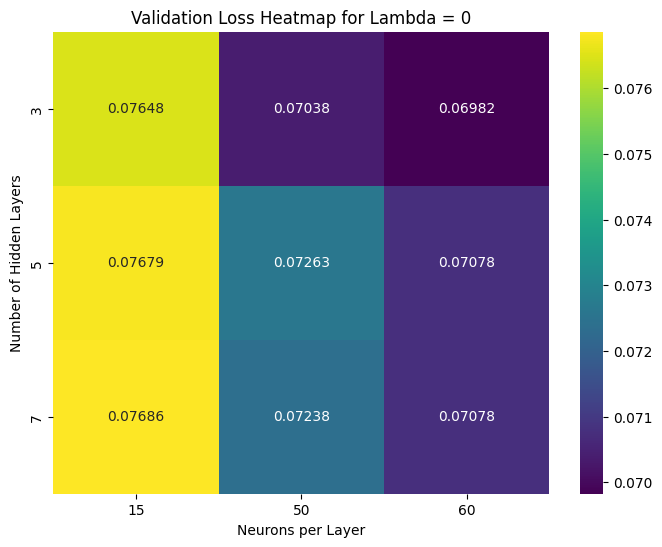

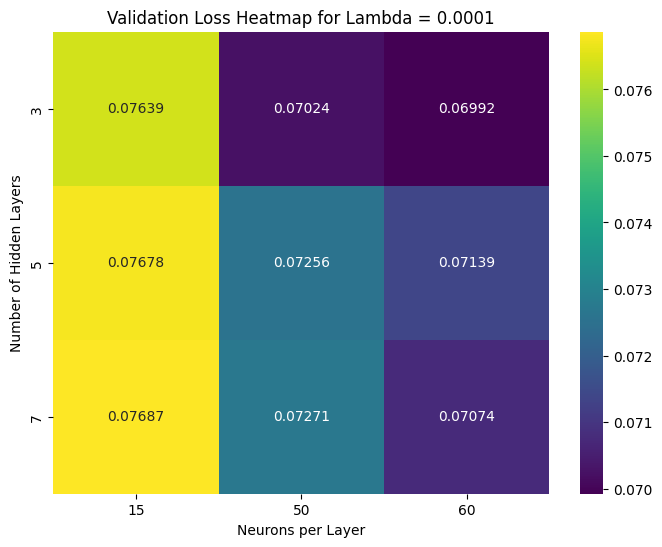

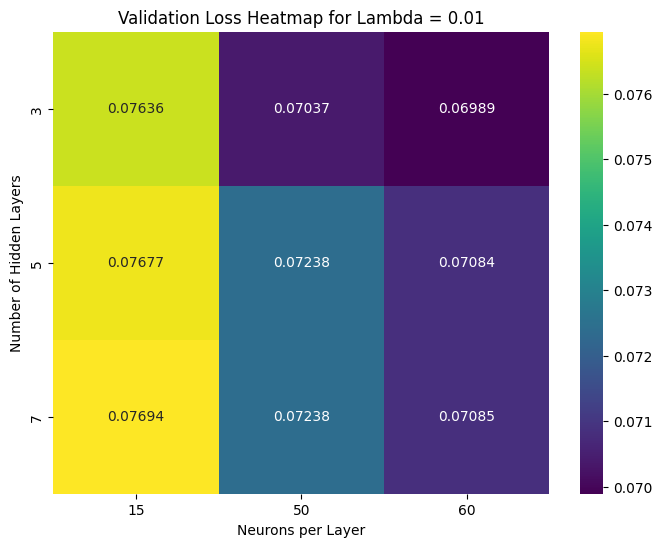

In [3]:
## your code goes here:
features = 8
predictions = 2

dataset_energy = pd.read_csv("data/energy_efficiency.csv")

X = dataset_energy.drop(["Y1", "Y2"], axis=1).values #we will use as numpy array
y = dataset_energy[["Y1", "Y2"]].values #we will use as numpy array

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size=0.70, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.50, random_state=42)

#stantardize the data to prevent overflow
scaler = MyStandardScaler()
X_train_normalized = np.array(scaler.fit_transform(X_train))
X_val_normalized = np.array(scaler.transform(X_val))
X_test_normalized = np.array(scaler.transform(X_test))

#define the parameter grid 
param_grid = {
    'num_layers': [3, 5, 7],
    'num_neurons': [15, 50, 60],
    'lambda': [0, 0.0001, 0.01]
}

#perform grid search
grid_search = GridSearch(Network, param_grid)
grid_search.fit(X_train_normalized, y_train, X_val_normalized, y_val, epochs=50, learning_rate=0.03)

#plot heatmaps
grid_search.plot_heatmaps()

#best model parameters
best_params = grid_search.best_params_

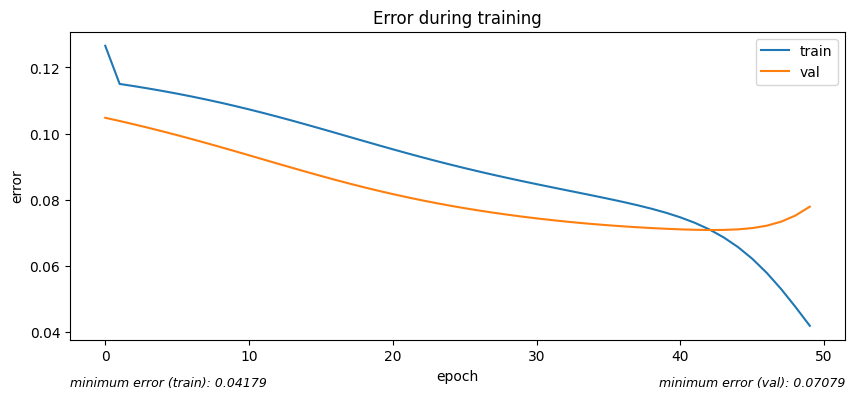

The best model was trained using: {'num_layers': 3, 'num_neurons': 60, 'lambda': 0}

The final score achieved was (RMSE): 0.27903


In [4]:
#best model train
num_layers = best_params["num_layers"]
num_neurons = best_params["num_neurons"]
alpha = best_params["lambda"]

#put together the train and validation set to use in the final model
X_train_completo = np.concatenate((X_train_normalized, X_val_normalized))
y_train_completo = np.concatenate((y_train, y_val))

network = Network()

#use the test set here to analyse the mse during the train
network.use(mse, mse_prime, X_test_normalized, y_test, alpha=alpha)
                    
#first layer
network.add(Layer(X_train_completo.shape[1], num_neurons, sigmoid, sigmoid_deriv))

#hiddens layers
for _ in range(1, num_layers):
    #all layers have the same number of neurons
    network.add(Layer(num_neurons, num_neurons, sigmoid, sigmoid_deriv))

#output layer
network.add(Layer(num_neurons, y_train_completo.shape[1], identity, identity_deriv))

#train and use the network
network.fit(X_train_completo, y_train_completo, epochs=50, learning_rate=0.03, print_erro=False)
y_pred = network.predict(X_test_normalized)

#get and show performance metrics
final_score = np.sqrt(mse(y_test, y_pred))
network.plot_errors()

print(f"The best model was trained using: {best_params}\n\nThe final score achieved was (RMSE): {(final_score):.5f}")

# Classification

**Download the data from ECLASS**
- drug_side_effects.csv
- drug_features.csv

**Dataset description:**

In this exercise, you will build and train a neural network to predict the occurrence of drug side effects. The dataset is derived from the SIDER dataset, containing relatively common side effects that can occur for at least 50 drugs. This produces a total of 740 drugs and 256 side effects. The features represent various molecular properties, including molecular weight, number of atoms, number of rings, number of hydrogen bond donors and acceptors, logP, topological polar surface area (TPSA), number of rotatable bonds, number of aromatic rings, number of aliphatic rings, number of saturated rings, and number of heteroatoms. 

**Remember that each drug can cause many side effects, not only one.** 

*Feel free to explore the dataset and check the potential side effects of popular medications!*

### To complete this exercise, follow these steps:

1. Load the dataset and split it into training, validation, and test sets, using an 80:10:10 ratio. 

2. Standardize the features by removing the mean and scaling to unit variance. To do this, perform the following for each feature (column) in the dataset:
    - Calculate the mean and standard deviation across the training set for that feature.
    - Subtract the mean from each value in that feature and divide by the standard deviation.
    - Apply the same transformation to the validation and test sets using the mean and standard deviation calculated from the training set.

**Observation:** you need to code this part, you’re not allowed to use scikit-learn.

*Normalization of features is important for neural networks because:*
- *It ensures that all features have the same scale, preventing certain features from dominating the learning process due to their larger magnitude.*
- *It improves the numerical stability of the training process, making the neural network less sensitive to the choice of learning rate and other hyperparameters.*

3. Build a neural network using NumPy that takes in the features as input and predicts the occurrence of side effects. You will choose the number of neurons per layer and the number of layers. You will provide this information as an input list where the length of the list determines the number of hidden layers, and each element is the number of neurons of that hidden layer. For example, an array `layers = [64,128,256]` should produce a network with 4 layers, with 3 hidden layers with 64, 128, and 256 neurons each. For the hidden layers use the sigmoid activation function. You will need to regularize your neural network using weight decay, that is, you will include a regularization term in your error function.

4. Code the forward pass and backpropagation algorithm to learn the weights of the neural network. Use the training set to train the neural network and update the weights using stochastic gradient descent. Don’t forget about the biases. 

5. Monitor the training by plotting the training and validation losses across the epochs.

	**Observation:** make sure the loss goes down during training, acceptable values are within 0.2 – 2.8 approximately. These values depend on the choice of the different hyperparameters. Test only sensible values taking into account the dataset, i.e., number of features, drugs, side effects. 

The performance of your neural network will be different depending on the number of layers, number of neurons per layer and the value of λ that controls the amount of weight decay. You will experiment with 3 values of λ: 0 (no weight decay), 1 and 0.01.
To choose the best network configuration and assess its performance you will:

1. For each value of λ, select 3 different layer configurations (note that in this exercise, the number of neurons per layer does not require to be the same for each layer).
2. Calculate the loss for each configuration on the validation set.
3. At the end of this process, you should be left with 9 loss values (one for each configuration). Train your final model selecting the best combination of hyper-parameters and evaluate the final performance of the neural network using the test set and the Area Under the ROC Curve (AUROC) with the function provided in the Jupyter notebook. 
	
	*Observation: don’t expect impressive AUROC values, as this is a highly complex problem that can’t be solved easily with a simple neural network with standard features. Expect values in the range (0.55-0.75).*

**Important:**
- Train for 50 epochs.
- Set the learning rate η to 0.01.



In [5]:
###-----  GridSearchClassification, to choose hyper-parameter -----### 
class GridSearchClassification:
    """
    grid search for hyperparameter tuning using a neural network model.
    """
    def __init__(self, model, layers, lambdas):
        """
        initialize the grid search.
        
        Args:
            layers: [[num_neurons, num_neurons],[...],[...]] (list of lists)
            lambdas: [n1, n2, n3, ...] (list)
        """
        self.model = model
        self.layers_config = layers
        self.lambdas = lambdas
        self.best_params_ = None
        self.best_score_ = None
        self.validation_losses = []
    
    def fit(self, X_train, y_train, X_val, y_val, epochs, learning_rate):
        """
        perform grid search to find the best hyperparameters.
        """
        best_score = float('inf')
        best_params = None

        #create a network for each combination and test it
        for alpha in self.lambdas:
            for layers in self.layers_config:
                network = self.model()
                network.use(cross_entropy, cross_entropy_prime, X_val, y_val, alpha=alpha)
                
                num_neurons = layers[0]
                
                #first layer
                network.add(Layer(X_train.shape[1], num_neurons, sigmoid, sigmoid_deriv))
                
                last_num_neurons = num_neurons
                
                #hiddens layers
                for num_neurons in layers[1:]:
                    network.add(Layer(last_num_neurons, num_neurons, sigmoid, sigmoid_deriv))
                    last_num_neurons = num_neurons
                    
                #output layer
                network.add(Layer(last_num_neurons, y_train.shape[1], sigmoid, sigmoid_deriv))

                network.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate, print_erro=False)
                score = network.errors_during_train_val[-1]  #using validation error as the score

                if score < best_score:
                    best_score = score
                    best_params = (layers, alpha)

                self.validation_losses.append((layers, alpha, score))

        self.best_params_ = dict(Layers = best_params[0], Lambda = best_params[1]) 
        self.best_score_ = best_score

In [6]:
## your code goes here: 
dataset_drug_side_effect = pd.read_csv("data/drug_side_effects.csv").values #we will use as numpy array
dataset_drug_features = pd.read_csv("data/drug_features.csv").values #we will use as numpy array

#check if X and y align
if np.any(dataset_drug_side_effect[:, 0] != dataset_drug_features[:, 0]): raise Exception("X and y are not align")

X_class = dataset_drug_features[:, 1:].astype(float)
y_class = dataset_drug_side_effect[:, 1:].astype(float)

X_train_class, X_test_val_class, y_train_class, y_test_val_class = train_test_split(X_class, y_class, train_size=0.80, random_state=42)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(X_test_val_class, y_test_val_class, test_size=0.50, random_state=42)

#stantardize the data
scaler_class = MyStandardScaler()
X_train_normalized_class = np.array(scaler.fit_transform(X_train_class))
X_val_normalized_class = np.array(scaler.transform(X_val_class))
X_test_normalized_class = np.array(scaler.transform(X_test_class))

#define layer configurations and alpha
layers_config = [[60, 110, 40, 90], [60, 90, 50, 80], [50, 100, 40, 90]]
alphas = [0, 0.01, 1]

#perform grid search
grid_search_class = GridSearchClassification(Network, layers_config, alphas)
grid_search_class.fit(X_train_normalized_class, y_train_class, X_val_normalized_class, y_val_class, epochs=50, learning_rate=0.01)

#best model parameters
best_params_class = grid_search_class.best_params_

print(f"The best hyper-parameters are: {best_params_class}\n\nAchieving {grid_search_class.best_score_:.5f} score.")

The best hyper-parameters are: {'Layers': [60, 90, 50, 80], 'Lambda': 0.01}

Achieving 0.62714 score.


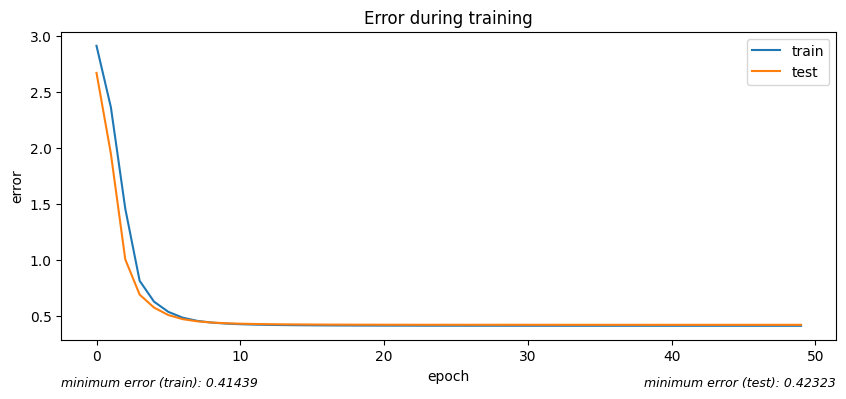

The best model was trained using: {'Layers': [60, 90, 50, 80], 'Lambda': 0.01}

The final score achieved was (Cross Entropy): 0.42324


In [7]:
#best model train
layers_best = best_params_class["Layers"]
alpha_best = best_params_class["Lambda"]

# put together the train and validation set to use in the final model
X_train_completo_class = np.concatenate((X_train_normalized_class, X_val_normalized_class))
y_train_completo_class = np.concatenate((y_train_class, y_val_class))

network = Network()

# use the test set here to analyse the mse during the train
network.use(cross_entropy, cross_entropy_prime, X_test_normalized_class, y_test_class, alpha=alpha)
                    
num_neurons = layers_best[0]
                
#first layer
network.add(Layer(X_train_completo_class.shape[1], num_neurons, sigmoid, sigmoid_deriv))

last_num_neurons = num_neurons

#hiddens layers
for num_neurons in layers_best[1:]:
    network.add(Layer(last_num_neurons, num_neurons, sigmoid, sigmoid_deriv))
    last_num_neurons = num_neurons
    
#output layer
network.add(Layer(last_num_neurons, y_train_completo_class.shape[1], sigmoid, sigmoid_deriv))

#train and use the network
network.fit(X_train_completo_class, y_train_completo_class, epochs=50, learning_rate=0.1, print_erro=False)
y_pred_class = network.predict(X_test_normalized_class)

#get and show performance metrics
final_score = cross_entropy(y_test_class, y_pred_class)
network.plot_errors(val_or_test = "test")

print(f"The best model was trained using: {best_params_class}\n\nThe final score achieved was (Cross Entropy): {(final_score):.5f}")

In [8]:
## to calculate the test set AUROC use the following code:
auroc = roc_auc_score(y_test_class, y_pred_class.reshape(y_pred_class.shape[0], y_pred_class.shape[-1]))
auroc

0.6088296365342442

### OBS:
Não plotei todos os gráficos durante o GridSearch, pois fica muito poluido. Resolvi plotar apenas os gráficos durante o treinamento do melhor modelo.  

Contudo, a classe possui a capacidade de plotar o gráfico, então é muito simples alterar para que sejam plotados a cada teste no GridSearch. Vou deixar o código necessário para isso comentado.